# Idea & Plan

A few (mostly one) latent feature is always much more important for prediction than the rest (check `feature_importance`) 

- Are the CpGs connected to this latent feature also important? 
- Can we recover the CpGs important for prediction through perturbation? --> **PROOF OF CONCEPT THAT PERTURBATIONS WORK?!**

**Workflow**:

1. Predict with input CpGs: maximum R2?
2. Predict with all latent features: maximum R2 + important latent features? 
3. Predict only with important latent feature --> this is the maximum we can achieve!
4. Recover CpGs connected to this latent feature through perturbations (`low` + `medium` + `high` effect)
5. Predict AGE with those CpGs --> compare to other results!

In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
#import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, RocCurveDisplay


In [39]:
def RFclassification(X_train, y_train, X_test, y_test, saveModel=False, plot=True, color="orange", title=None):
    ## Remove samples with NA in target
    # Train
    mask_train = ~np.isnan(y_train)
    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    # Test
    mask_test = ~np.isnan(y_test)
    X_test = X_test[mask_test]
    y_test = y_test[mask_test]

    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Train RFregression model
    clf = RandomForestClassifier(random_state=None)
    clf.fit(X_train, y_train)
    featureImportances = clf.feature_importances_

    # Score on Test set
    y_pred = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {auc}")

    if saveModel:
        # save model
        outPath = f"logs/{name}/classification/"
        os.makedirs(outPath, exist_ok=True)
        pickle.dump(regr, open(f"{outPath}/RFclassifier.sav", 'wb'))

    if plot:
        fig, (ax, ax2) = plt.subplots(1, 2,figsize=(15,5))
        RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, color=color)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
#        ax.text(0.8, .1, f"AUC = {round(auc,2)}")
#         ax.set_xlim(0,1)
#         ax.set_ylim(0,1)
        if title: 
            ax.set_title(f"{title}")
        else: 
            ax.set_title(f"{X_train.shape[1]} features")

        ax2.bar(x=range(len(featureImportances)), height=featureImportances, color=color)
        ax2.set_title("Feature importance")
        ax2.set_xlabel("# Feature")

    return featureImportances, auc

# Load Data

In [40]:
PATH_data = "data"
PATH_results = "logs"

batch_size = 64
with open(os.path.join(PATH_data, "chr5_smoking_train.pkl"), "rb") as f: train_dataset = pickle.load(f) #
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr5_smoking_train.pkl", colName="SMOKING").returnTensor_()

with open(os.path.join(PATH_data, "chr5_smoking_test.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Read in AE model 

In [45]:
name = f"smoking_chr5/latSize_200"  #f"smoking_chr5/latSize_50_3hidden" 
global name
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

# From all latent space features

ROC-AUC: 0.8277027027027027


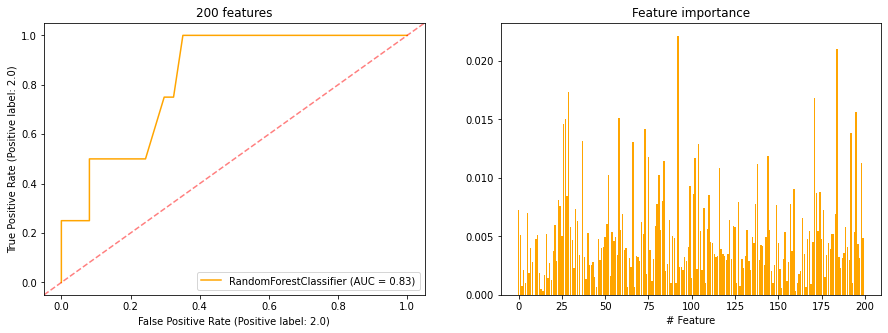

In [46]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)  

fi, auc = RFclassification(X_train=latSpace_train, 
                     y_train=train_tensor[1].detach().numpy(),
                     X_test=latSpace_test,
                     y_test=test_dataset["pheno"]["SMOKING"].values,
                     plot=True,
                     color="orange")

df_fi = pd.DataFrame(fi, index=range(latSpace_train.size(1)), columns=["fi"])
#df_fi

# From input CpGs 

## All input CpGs (24247 CpGs)

ROC-AUC: 0.929054054054054


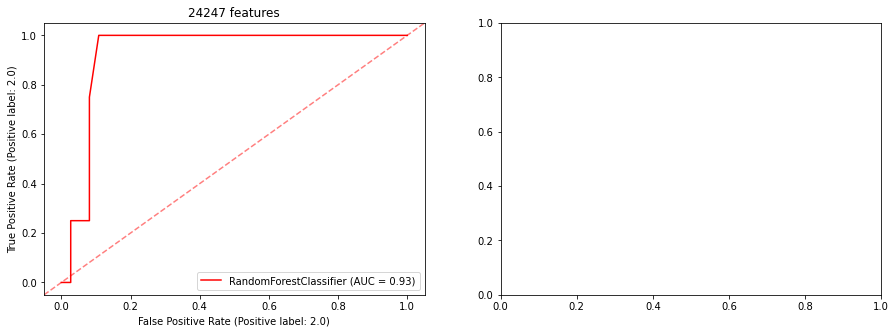

In [35]:
# fi_all, _ = RFclassification(X_train=train_tensor[0].detach().numpy(), 
#                          y_train=train_tensor[1].detach().numpy(),
#                          X_test=test_dataset["beta"].values,
#                          y_test=test_dataset["pheno"]["SMOKING"].values,
#                          plot=True,
#                          color="red")

## Top xx input Cpgs

- tried Recursive Feature Addition - too slow

ROC-AUC: 0.9864864864864865
Index(['cg05575921', 'cg21161138', 'cg00300637', 'cg02565255', 'cg08215255',
       'cg11449735', 'cg18911817', 'cg27320005', 'cg23916896', 'cg26363603'],
      dtype='object', name='ID_REF')


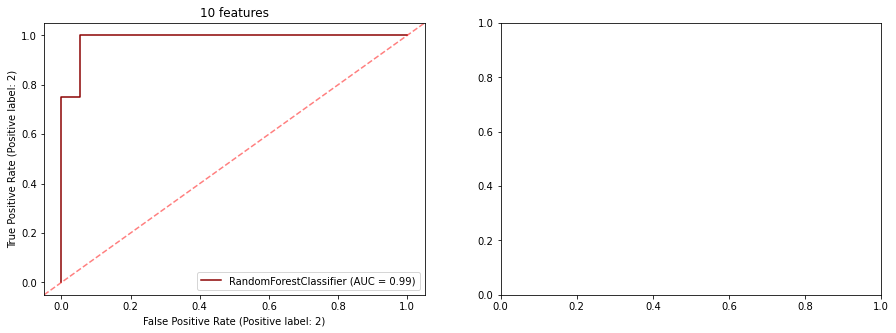

In [36]:
### Test: with xx best CpGs (from input)
i_best = 10
cpgs_best = pd.DataFrame(fi_all, index=test_dataset["beta"].columns).sort_values(by=0, ascending=False)[:i_best].index

## parse only CpGs connected to latent feature 
X_train_latFeature = train_dataset["beta"].loc[:,cpgs_best]
y_train_latFeature = train_dataset["pheno"]["SMOKING"].values
X_test_latFeature = test_dataset["beta"].loc[:,cpgs_best]
y_test_latFeature = test_dataset["pheno"]["SMOKING"].values

## predict with those CpGs
_, auc = RFclassification(X_train=X_train_latFeature, 
                                y_train=y_train_latFeature,
                                X_test=X_test_latFeature,
                                y_test=y_test_latFeature,
                                plot=True,
                                color="darkred")

print(cpgs_best)